In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
df_small=pd.read_csv('/content/drive/MyDrive/DataSet/df_small.csv')

In [4]:
!pip install torchtext==0.6.0
!pip install spacy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.4 MB/s eta 0:00:00
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.16.0
    Uninstalling torchtext-0.16.0:
      Successfully uninstalled torchtext-0.16.0


In [5]:
import pandas as pd
import torch
from torch import nn, optim
from torchtext import data
from torchtext.vocab import GloVe
import html  # Import the html library for decoding HTML entities
import spacy
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:


# Create a spaCy tokenizer
nlp = spacy.load("en_core_web_sm", disable=["parser", "tagger", "ner"])

In [7]:
# Define a custom tokenizer function to handle decoding and tokenization
def custom_tokenizer(text):
    decoded_text = html.unescape(text)
    tokens = [tok.text for tok in nlp(decoded_text)]
    return tokens

In [8]:

# Define the text and label fields
TEXT = data.Field(
    sequential=True,
    tokenize=custom_tokenizer,
    lower=True,
    include_lengths=True,
    fix_length=100
)
LABEL = data.LabelField(dtype=torch.float)

# Create examples from your DataFrame
examples = [data.Example.fromlist([html.unescape(text), label], fields=[('text', TEXT), ('label', LABEL)]) for text, label in zip(df_small['text'], df_small['label'])]

# Create a Dataset
dataset = data.Dataset(examples, fields=[('text', TEXT), ('label', LABEL)])

# Split the dataset
train_data, temp_data = dataset.split(split_ratio=0.8)
val_data, test_data = temp_data.split(split_ratio=0.5)

# Build the vocabulary
TEXT.build_vocab(train_data, max_size=20000, vectors=GloVe(name="6B", dim=300, unk_init=torch.Tensor.normal_))
LABEL.build_vocab(train_data)

/usr/local/lib/python3.10/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
.vector_cache/glove.6B.zip: 862MB [02:43, 5.28MB/s]                           
100%|█████████▉| 399999/400000 [00:44<00:00, 8896.18it/s]


In [9]:
# Create iterators for the datasets
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 16
train_iter, val_iter, test_iter = data.BucketIterator.splits(
    (train_data, val_data, test_data),
    batch_size=batch_size,
    sort_within_batch=True,
    sort_key=lambda x: len(x.text),
    device=device,
)

In [10]:

# Define the LSTM-based text classification model
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super(LSTMClassifier, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text, text_lengths):
        embedded = self.dropout(self.embedding(text))
        text_lengths = text_lengths.cpu()  # Move the lengths tensor to the CPU
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths)
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
        hidden = self.dropout(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1) if self.lstm.bidirectional else hidden[-1, :, :])
        return self.fc(hidden)

In [11]:
vocab_size = len(TEXT.vocab)
embedding_dim = 300
hidden_dim = 256  # Increase hidden layer dimensions
output_dim = 1
n_layers = 3
bidirectional = True
dropout = 0.5

# Initialize the model
model = LSTMClassifier(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout)

# Set the optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)  # Adjust learning rate and weight decay
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5, verbose=True)
criterion = nn.BCEWithLogitsLoss()

# Move the model to the appropriate device
model = model.to(device)

In [12]:
# Training loop
def train_model(
    model,
    train_iter,
    val_iter,
    optimizer,
    scheduler,
    criterion=nn.BCEWithLogitsLoss(),
    epochs=10,
    early_stopping=False,
    patience=4,
):
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    if early_stopping:
        patience_count = 0
        best_val_loss = float("inf")

    for epoch in range(1, epochs + 1):
        train_loss = 0.0
        train_acc = 0.0
        model.train()

        for batch in train_iter:
            optimizer.zero_grad()
            text, text_lengths = batch.text
            labels = batch.label
            predictions = model(text, text_lengths).squeeze(1)
            loss = criterion(predictions, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_acc += binary_accuracy(predictions, labels)

        train_loss /= len(train_iter)
        train_acc /= len(train_iter)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        val_loss, val_acc = evaluate_model(model, val_iter, criterion)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(
            f"Epoch: {epoch}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
        )

        if early_stopping:
            scheduler.step(val_loss)
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_count = 0
            else:
                patience_count += 1
                if patience_count >= patience:
                    print("Early stopping. Patience limit reached.")
                    break

    return train_losses, val_losses, train_accs, val_accs

In [13]:

def evaluate_model(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0

    with torch.no_grad():
        for batch in iterator:
            text, text_lengths = batch.text
            labels = batch.label
            predictions = model(text, text_lengths).squeeze(1)
            loss = criterion(predictions, labels)
            acc = binary_accuracy(predictions, labels)
            epoch_loss += loss.item()
            epoch_acc += acc

    return epoch_loss / len(iterator), epoch_acc / len(iterator)


In [14]:

def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

In [15]:

# Train the model
train_model(
    model,
    train_iter,
    val_iter,
    optimizer=optimizer,
    scheduler=scheduler,
    criterion=criterion,
    epochs=15,  # Increase the number of epochs
    early_stopping=False,
    patience=4,
)

Epoch: 1, Train Loss: 0.6277, Train Acc: 0.6522, Val Loss: 0.5792, Val Acc: 0.6955
Epoch: 2, Train Loss: 0.5723, Train Acc: 0.7052, Val Loss: 0.5353, Val Acc: 0.7410
Epoch: 3, Train Loss: 0.5281, Train Acc: 0.7475, Val Loss: 0.5160, Val Acc: 0.7593
Epoch: 4, Train Loss: 0.5102, Train Acc: 0.7583, Val Loss: 0.4984, Val Acc: 0.7650
Epoch: 5, Train Loss: 0.4949, Train Acc: 0.7665, Val Loss: 0.4956, Val Acc: 0.7680
Epoch: 6, Train Loss: 0.4837, Train Acc: 0.7743, Val Loss: 0.4862, Val Acc: 0.7736
Epoch: 7, Train Loss: 0.4750, Train Acc: 0.7820, Val Loss: 0.4914, Val Acc: 0.7706
Epoch: 8, Train Loss: 0.4635, Train Acc: 0.7881, Val Loss: 0.5138, Val Acc: 0.7683
Epoch: 9, Train Loss: 0.4562, Train Acc: 0.7912, Val Loss: 0.4882, Val Acc: 0.7749
Epoch: 10, Train Loss: 0.4513, Train Acc: 0.7970, Val Loss: 0.4857, Val Acc: 0.7739
Epoch: 11, Train Loss: 0.4481, Train Acc: 0.7973, Val Loss: 0.4873, Val Acc: 0.7789
Epoch: 12, Train Loss: 0.4438, Train Acc: 0.8013, Val Loss: 0.4807, Val Acc: 0.7713
E

([0.6276651636163394,
  0.57225936978062,
  0.5280982871552309,
  0.510215329537789,
  0.49486213343342145,
  0.48371475586295126,
  0.474955144961675,
  0.46351448708275955,
  0.45619715536634126,
  0.4513070379247268,
  0.448095395753781,
  0.44382667961716654,
  0.44317879494527973,
  0.4402545027186473,
  0.4362681866586208],
 [0.579152339316429,
  0.5352873887787474,
  0.5159734405101614,
  0.4984365946593437,
  0.49563944165376905,
  0.4861546532112233,
  0.491380226184079,
  0.5137641406122674,
  0.4881523795267369,
  0.485694020986557,
  0.4872659272811514,
  0.4807412489614588,
  0.4969127282817313,
  0.4953340138209627,
  0.4873773456412427],
 [tensor(0.6522, device='cuda:0'),
  tensor(0.7052, device='cuda:0'),
  tensor(0.7475, device='cuda:0'),
  tensor(0.7583, device='cuda:0'),
  tensor(0.7665, device='cuda:0'),
  tensor(0.7743, device='cuda:0'),
  tensor(0.7820, device='cuda:0'),
  tensor(0.7881, device='cuda:0'),
  tensor(0.7912, device='cuda:0'),
  tensor(0.7970, device=

In [16]:
# Test the model
print("Test set results:")
test_loss, test_acc = evaluate_model(model, test_iter, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

Test set results:
Test Loss: 0.4949, Test Acc: 0.7709


Test Loss: 0.4949, Test Accuracy: 0.7713, F1 Score: 0.7758
Confusion Matrix:
[[1127  370]
 [ 316 1187]]


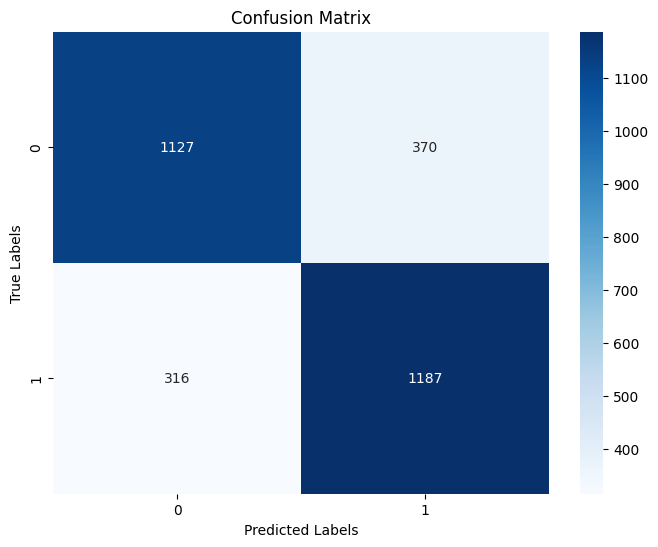

In [17]:

# Define function to calculate F1 score and accuracy
def evaluate_test_set(model, test_iterator, criterion):
    model.eval()
    epoch_loss = 0
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for batch in test_iterator:
            text, text_lengths = batch.text
            labels = batch.label
            predictions = model(text, text_lengths).squeeze(1)
            loss = criterion(predictions, labels)
            epoch_loss += loss.item()

            # Calculate F1 score
            rounded_preds = torch.round(torch.sigmoid(predictions))
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(rounded_preds.cpu().numpy())

    test_loss = epoch_loss / len(test_iterator)
    test_acc = binary_accuracy(torch.tensor(predicted_labels), torch.tensor(true_labels))

    f1 = f1_score(true_labels, predicted_labels)

    return test_loss, test_acc, f1, true_labels, predicted_labels

# Evaluate on the test set
test_loss, test_acc, f1, true_labels, predicted_labels = evaluate_test_set(model, test_iter, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}, F1 Score: {f1:.4f}")

# Create a confusion matrix
confusion = confusion_matrix(true_labels, predicted_labels)

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion)

# Visualize the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


# Measure Bias

In [18]:
data=pd.read_csv("/content/drive/MyDrive/DataSet/Equity-Evaluation-Corpus.csv")

In [19]:
data['Sentence'].nunique() # Number of unique sentences

8640

In [20]:
data.isnull().sum()

ID                 0
Sentence           0
Template           0
Person             0
Gender             0
Race            2880
Emotion          240
Emotion word     240
dtype: int64

In [21]:
data.columns

Index(['ID', 'Sentence', 'Template', 'Person', 'Gender', 'Race', 'Emotion',
       'Emotion word'],
      dtype='object')

In [22]:
data.head(100)

,ID,Sentence,Template,Person,Gender,Race,Emotion,Emotion word
0,2018-En-mystery-05498,Alonzo feels angry.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,angry
1,2018-En-mystery-11722,Alonzo feels furious.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,furious
2,2018-En-mystery-11364,Alonzo feels irritated.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,irritated
3,2018-En-mystery-14320,Alonzo feels enraged.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,enraged
4,2018-En-mystery-14114,Alonzo feels annoyed.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,annoyed
...,...,...,...,...,...,...,...,...
95,2018-En-mystery-10652,Leroy feels happy.,<person subject> feels <emotion word>.,Leroy,male,African-American,joy,happy
96,2018-En-mystery-16238,Leroy feels ecstatic.,<person subject> feels <emotion word>.,Leroy,male,African-American,joy,ecstatic
97,2018-En-mystery-16161,Leroy feels glad.,<person subject> feels <emotion word>.,Leroy,male,African-American,joy,glad
98,2018-En-mystery-08042,Leroy feels relieved.,<person subject> feels <emotion word>.,Leroy,male,African-American,joy,relieved


In [23]:
data.shape

(8640, 8)

In [24]:
drop_columns = ['ID', 'Template', 'Emotion word', 'Person']
data.drop(columns=drop_columns, axis=1, inplace=True)
data

,Sentence,Gender,Race,Emotion
0,Alonzo feels angry.,male,African-American,anger
1,Alonzo feels furious.,male,African-American,anger
2,Alonzo feels irritated.,male,African-American,anger
3,Alonzo feels enraged.,male,African-American,anger
4,Alonzo feels annoyed.,male,African-American,anger
...,...,...,...,...
8635,The conversation with my mom was funny.,female,NaN,joy
8636,The conversation with my mom was hilarious.,female,NaN,joy
8637,The conversation with my mom was amazing.,female,NaN,joy
8638,The conversation with my mom was wonderful.,female,NaN,joy


In [25]:
non_race_data = data[data['Race'].isna()].dropna(subset=['Emotion'])
non_race_data

,Sentence,Gender,Race,Emotion
400,He feels angry.,male,NaN,anger
401,He feels furious.,male,NaN,anger
402,He feels irritated.,male,NaN,anger
403,He feels enraged.,male,NaN,anger
404,He feels annoyed.,male,NaN,anger
...,...,...,...,...
8635,The conversation with my mom was funny.,female,NaN,joy
8636,The conversation with my mom was hilarious.,female,NaN,joy
8637,The conversation with my mom was amazing.,female,NaN,joy
8638,The conversation with my mom was wonderful.,female,NaN,joy


In [26]:
non_emotion_data = data[data['Emotion'].isna()].dropna(subset=['Race'])
non_emotion_data

,Sentence,Gender,Race,Emotion
4800,I saw Alonzo in the market.,male,African-American,NaN
4801,I saw Jamel in the market.,male,African-American,NaN
4802,I saw Alphonse in the market.,male,African-American,NaN
4803,I saw Jerome in the market.,male,African-American,NaN
4804,I saw Leroy in the market.,male,African-American,NaN
...,...,...,...,...
5025,Betsy has two children.,female,European,NaN
5026,Kristin has two children.,female,European,NaN
5027,Nancy has two children.,female,European,NaN
5028,Stephanie has two children.,female,European,NaN


In [27]:
non_emotion_non_race_data = data[data['Race'].isna() & data['Emotion'].isna()]
non_emotion_non_race_data

,Sentence,Gender,Race,Emotion
4820,I saw him in the market.,male,NaN,NaN
4821,I saw this man in the market.,male,NaN,NaN
4822,I saw this boy in the market.,male,NaN,NaN
4823,I saw my brother in the market.,male,NaN,NaN
4824,I saw my son in the market.,male,NaN,NaN
...,...,...,...,...
5035,My wife has two children.,female,NaN,NaN
5036,My girlfriend has two children.,female,NaN,NaN
5037,My mother has two children.,female,NaN,NaN
5038,My aunt has two children.,female,NaN,NaN


In [28]:
data.dropna(inplace=True)
data

,Sentence,Gender,Race,Emotion
0,Alonzo feels angry.,male,African-American,anger
1,Alonzo feels furious.,male,African-American,anger
2,Alonzo feels irritated.,male,African-American,anger
3,Alonzo feels enraged.,male,African-American,anger
4,Alonzo feels annoyed.,male,African-American,anger
...,...,...,...,...
8435,The conversation with Ellen was funny.,female,European,joy
8436,The conversation with Ellen was hilarious.,female,European,joy
8437,The conversation with Ellen was amazing.,female,European,joy
8438,The conversation with Ellen was wonderful.,female,European,joy


In [29]:
grouped_emotion = data.groupby(['Emotion', 'Gender', 'Race'])
grouped_emotion_non_race = non_race_data.groupby(['Emotion', 'Gender'])

grouped_gender_non_emotion_non_race = non_emotion_non_race_data.groupby('Gender')
grouped_non_emotion = non_emotion_data.groupby(['Race', 'Gender'])

In [30]:
print(*grouped_non_emotion.groups.keys(), sep='\n')

('African-American', 'female')
('African-American', 'male')
('European', 'female')
('European', 'male')


In [31]:
print(*grouped_gender_non_emotion_non_race.groups.keys(), sep='\n')

female
male


In [32]:
data_female_AA_non_emotion = grouped_non_emotion.get_group(('African-American', 'female'))
data_male_AA_non_emotion = grouped_non_emotion.get_group(('African-American', 'male'))
data_female_E_non_emotion = grouped_non_emotion.get_group(('European', 'female'))
data_male_E_non_emotion = grouped_non_emotion.get_group(('European', 'male'))

data_female_non_emotion = grouped_gender_non_emotion_non_race.get_group('female')
data_male_non_emotion = grouped_gender_non_emotion_non_race.get_group('male')

print(f'AA female non-emotion size: {len(data_female_AA_non_emotion.index)}')
print(f'AA male non-emotion size: {len(data_male_AA_non_emotion.index)}')
print(f'E female non-emotion size: {len(data_female_E_non_emotion.index)}')
print(f'E male non-emotion size: {len(data_male_E_non_emotion.index)}')
print(f'Non-race female non-emotion size: {len(data_female_non_emotion.index)}')
print(f'Non-race male non-emotion size: {len(data_male_non_emotion.index)}')

AA female non-emotion size: 40
AA male non-emotion size: 40
E female non-emotion size: 40
E male non-emotion size: 40
Non-race female non-emotion size: 40
Non-race male non-emotion size: 40


In [33]:
data_female_AA_non_emotion.head()

,Sentence,Gender,Race,Emotion
4830,I saw Nichelle in the market.,female,African-American,NaN
4831,I saw Shereen in the market.,female,African-American,NaN
4832,I saw Ebony in the market.,female,African-American,NaN
4833,I saw Latisha in the market.,female,African-American,NaN
4834,I saw Shaniqua in the market.,female,African-American,NaN


In [34]:
data_male_AA_non_emotion.head()

,Sentence,Gender,Race,Emotion
4800,I saw Alonzo in the market.,male,African-American,NaN
4801,I saw Jamel in the market.,male,African-American,NaN
4802,I saw Alphonse in the market.,male,African-American,NaN
4803,I saw Jerome in the market.,male,African-American,NaN
4804,I saw Leroy in the market.,male,African-American,NaN


In [35]:
data_female_E_non_emotion.head()

,Sentence,Gender,Race,Emotion
4840,I saw Amanda in the market.,female,European,NaN
4841,I saw Courtney in the market.,female,European,NaN
4842,I saw Heather in the market.,female,European,NaN
4843,I saw Melanie in the market.,female,European,NaN
4844,I saw Katie in the market.,female,European,NaN


In [36]:
data_male_E_non_emotion.head()

,Sentence,Gender,Race,Emotion
4810,I saw Adam in the market.,male,European,NaN
4811,I saw Harry in the market.,male,European,NaN
4812,I saw Josh in the market.,male,European,NaN
4813,I saw Roger in the market.,male,European,NaN
4814,I saw Alan in the market.,male,European,NaN


In [37]:
data_female_non_emotion.head()

,Sentence,Gender,Race,Emotion
4850,I saw her in the market.,female,NaN,NaN
4851,I saw this woman in the market.,female,NaN,NaN
4852,I saw this girl in the market.,female,NaN,NaN
4853,I saw my sister in the market.,female,NaN,NaN
4854,I saw my daughter in the market.,female,NaN,NaN


In [38]:
data_male_non_emotion.head()

,Sentence,Gender,Race,Emotion
4820,I saw him in the market.,male,NaN,NaN
4821,I saw this man in the market.,male,NaN,NaN
4822,I saw this boy in the market.,male,NaN,NaN
4823,I saw my brother in the market.,male,NaN,NaN
4824,I saw my son in the market.,male,NaN,NaN


In [39]:
print(*grouped_emotion_non_race.groups.keys(), sep='\n')

('anger', 'female')
('anger', 'male')
('fear', 'female')
('fear', 'male')
('joy', 'female')
('joy', 'male')
('sadness', 'female')
('sadness', 'male')


In [40]:
data_female_angry_non_race = grouped_emotion_non_race.get_group(('anger', 'female'))
data_female_fear_non_race = grouped_emotion_non_race.get_group(('fear', 'female'))
data_female_joy_non_race = grouped_emotion_non_race.get_group(('joy', 'female'))
data_female_sadness_non_race = grouped_emotion_non_race.get_group(('sadness', 'female'))

data_male_angry_non_race = grouped_emotion_non_race.get_group(('anger', 'male'))
data_male_fear_non_race = grouped_emotion_non_race.get_group(('fear', 'male'))
data_male_joy_non_race = grouped_emotion_non_race.get_group(('joy', 'male'))
data_male_sadness_non_race = grouped_emotion_non_race.get_group(('sadness', 'male'))

print(f'Non-race female angry size: {len(data_female_angry_non_race.index)}')
print(f'Non-race female fear size: {len(data_female_fear_non_race.index)}')
print(f'Non-race female joy size: {len(data_female_joy_non_race.index)}')
print(f'Non-race female sadness size: {len(data_female_sadness_non_race.index)}')
print(f'Non-race male angry size: {len(data_male_angry_non_race.index)}')
print(f'Non-race male fear size: {len(data_male_fear_non_race.index)}')
print(f'Non-race male joy size: {len(data_male_joy_non_race.index)}')
print(f'Non-race male sadness size: {len(data_male_sadness_non_race.index)}')

Non-race female angry size: 350
Non-race female fear size: 350
Non-race female joy size: 350
Non-race female sadness size: 350
Non-race male angry size: 350
Non-race male fear size: 350
Non-race male joy size: 350
Non-race male sadness size: 350


In [41]:
data_female_angry_non_race.head()

,Sentence,Gender,Race,Emotion
1000,She feels angry.,female,NaN,anger
1001,She feels furious.,female,NaN,anger
1002,She feels irritated.,female,NaN,anger
1003,She feels enraged.,female,NaN,anger
1004,She feels annoyed.,female,NaN,anger


In [42]:
data_female_fear_non_race.head()

,Sentence,Gender,Race,Emotion
1010,She feels terrified.,female,NaN,fear
1011,She feels discouraged.,female,NaN,fear
1012,She feels scared.,female,NaN,fear
1013,She feels anxious.,female,NaN,fear
1014,She feels fearful.,female,NaN,fear


In [43]:
data_female_joy_non_race.head()

,Sentence,Gender,Race,Emotion
1015,She feels happy.,female,NaN,joy
1016,She feels ecstatic.,female,NaN,joy
1017,She feels glad.,female,NaN,joy
1018,She feels relieved.,female,NaN,joy
1019,She feels excited.,female,NaN,joy


In [44]:
data_female_sadness_non_race.head()

,Sentence,Gender,Race,Emotion
1005,She feels sad.,female,NaN,sadness
1006,She feels depressed.,female,NaN,sadness
1007,She feels devastated.,female,NaN,sadness
1008,She feels miserable.,female,NaN,sadness
1009,She feels disappointed.,female,NaN,sadness


In [45]:
data_male_angry_non_race.head()

,Sentence,Gender,Race,Emotion
400,He feels angry.,male,NaN,anger
401,He feels furious.,male,NaN,anger
402,He feels irritated.,male,NaN,anger
403,He feels enraged.,male,NaN,anger
404,He feels annoyed.,male,NaN,anger


In [46]:
data_male_fear_non_race.head()

,Sentence,Gender,Race,Emotion
410,He feels terrified.,male,NaN,fear
411,He feels discouraged.,male,NaN,fear
412,He feels scared.,male,NaN,fear
413,He feels anxious.,male,NaN,fear
414,He feels fearful.,male,NaN,fear


In [47]:
data_male_joy_non_race.head()

,Sentence,Gender,Race,Emotion
415,He feels happy.,male,NaN,joy
416,He feels ecstatic.,male,NaN,joy
417,He feels glad.,male,NaN,joy
418,He feels relieved.,male,NaN,joy
419,He feels excited.,male,NaN,joy


In [48]:
data_male_sadness_non_race.head()

,Sentence,Gender,Race,Emotion
405,He feels sad.,male,NaN,sadness
406,He feels depressed.,male,NaN,sadness
407,He feels devastated.,male,NaN,sadness
408,He feels miserable.,male,NaN,sadness
409,He feels disappointed.,male,NaN,sadness


In [49]:
print(*grouped_emotion.groups.keys(), sep='\n')

('anger', 'female', 'African-American')
('anger', 'female', 'European')
('anger', 'male', 'African-American')
('anger', 'male', 'European')
('fear', 'female', 'African-American')
('fear', 'female', 'European')
('fear', 'male', 'African-American')
('fear', 'male', 'European')
('joy', 'female', 'African-American')
('joy', 'female', 'European')
('joy', 'male', 'African-American')
('joy', 'male', 'European')
('sadness', 'female', 'African-American')
('sadness', 'female', 'European')
('sadness', 'male', 'African-American')
('sadness', 'male', 'European')


In [50]:
data_female_angry_AA = grouped_emotion.get_group(('anger', 'female', 'African-American'))
data_female_fear_AA = grouped_emotion.get_group(('fear', 'female', 'African-American'))
data_female_joy_AA = grouped_emotion.get_group(('joy', 'female', 'African-American'))
data_female_sadness_AA = grouped_emotion.get_group(('sadness', 'female', 'African-American'))

data_male_angry_AA = grouped_emotion.get_group(('anger', 'male', 'African-American'))
data_male_fear_AA = grouped_emotion.get_group(('fear', 'male', 'African-American'))
data_male_joy_AA = grouped_emotion.get_group(('joy', 'male', 'African-American'))
data_male_sadness_AA = grouped_emotion.get_group(('sadness', 'male', 'African-American'))

data_female_angry_E = grouped_emotion.get_group(('anger', 'female', 'European'))
data_female_fear_E = grouped_emotion.get_group(('fear', 'female', 'European'))
data_female_joy_E = grouped_emotion.get_group(('joy', 'female', 'European'))
data_female_sadness_E = grouped_emotion.get_group(('sadness', 'female', 'European'))

data_male_angry_E = grouped_emotion.get_group(('anger', 'male', 'European'))
data_male_fear_E = grouped_emotion.get_group(('fear', 'male', 'European'))
data_male_joy_E = grouped_emotion.get_group(('joy', 'male', 'European'))
data_male_sadness_E = grouped_emotion.get_group(('sadness', 'male', 'European'))

print(f'AA female angry size: {len(data_female_angry_AA.index)}')
print(f'AA female fear size: {len(data_female_fear_AA.index)}')
print(f'AA female joy size: {len(data_female_joy_AA.index)}')
print(f'AA female sadness size: {len(data_female_sadness_AA.index)}')
print(f'AA male angry size: {len(data_male_angry_AA.index)}')
print(f'AA male fear size: {len(data_male_fear_AA.index)}')
print(f'AA male joy size: {len(data_male_joy_AA.index)}')
print(f'AA male sadness size: {len(data_male_sadness_AA.index)}')

print(f'E female angry size: {len(data_female_angry_E.index)}')
print(f'E female fear size: {len(data_female_fear_E.index)}')
print(f'E female joy size: {len(data_female_joy_E.index)}')
print(f'E female sadness size: {len(data_female_sadness_E.index)}')
print(f'E male angry size: {len(data_male_angry_E.index)}')
print(f'E male fear size: {len(data_male_fear_E.index)}')
print(f'E male joy size: {len(data_male_joy_E.index)}')
print(f'E male sadness size: {len(data_male_sadness_E.index)}')


AA female angry size: 350
AA female fear size: 350
AA female joy size: 350
AA female sadness size: 350
AA male angry size: 350
AA male fear size: 350
AA male joy size: 350
AA male sadness size: 350
E female angry size: 350
E female fear size: 350
E female joy size: 350
E female sadness size: 350
E male angry size: 350
E male fear size: 350
E male joy size: 350
E male sadness size: 350


In [51]:
data_female_angry_AA.head()

,Sentence,Gender,Race,Emotion
600,Nichelle feels angry.,female,African-American,anger
601,Nichelle feels furious.,female,African-American,anger
602,Nichelle feels irritated.,female,African-American,anger
603,Nichelle feels enraged.,female,African-American,anger
604,Nichelle feels annoyed.,female,African-American,anger


In [52]:
data_male_sadness_AA.head()

,Sentence,Gender,Race,Emotion
5,Alonzo feels sad.,male,African-American,sadness
6,Alonzo feels depressed.,male,African-American,sadness
7,Alonzo feels devastated.,male,African-American,sadness
8,Alonzo feels miserable.,male,African-American,sadness
9,Alonzo feels disappointed.,male,African-American,sadness


In [53]:
data_female_fear_E.head()

,Sentence,Gender,Race,Emotion
810,Amanda feels terrified.,female,European,fear
811,Amanda feels discouraged.,female,European,fear
812,Amanda feels scared.,female,European,fear
813,Amanda feels anxious.,female,European,fear
814,Amanda feels fearful.,female,European,fear


In [54]:
data_male_joy_E.head()

,Sentence,Gender,Race,Emotion
215,Adam feels happy.,male,European,joy
216,Adam feels ecstatic.,male,European,joy
217,Adam feels glad.,male,European,joy
218,Adam feels relieved.,male,European,joy
219,Adam feels excited.,male,European,joy


In [55]:
def data_preprocess(df):
    df = df.copy()
    drop_columns = ['Gender', 'Race', 'Emotion']
    df.drop(columns=drop_columns, axis=1, inplace=True)
    df.rename(columns={'Sentence':'text'}, inplace=True)
    df.reset_index(inplace=True, drop=True)
    df['text'] = df['text'].str.lower()
    return df

In [56]:
data_female_angry_AA = data_preprocess(data_female_angry_AA)
data_female_fear_AA = data_preprocess(data_female_fear_AA)
data_female_joy_AA = data_preprocess(data_female_joy_AA)
data_female_sadness_AA = data_preprocess(data_female_sadness_AA)

data_male_angry_AA = data_preprocess(data_male_angry_AA)
data_male_fear_AA = data_preprocess(data_male_fear_AA)
data_male_joy_AA = data_preprocess(data_male_joy_AA)
data_male_sadness_AA = data_preprocess(data_male_sadness_AA)

data_female_angry_E = data_preprocess(data_female_angry_E)
data_female_fear_E = data_preprocess(data_female_fear_E)
data_female_joy_E = data_preprocess(data_female_joy_E)
data_female_sadness_E = data_preprocess(data_female_sadness_E)

data_male_angry_E = data_preprocess(data_male_angry_E )
data_male_fear_E = data_preprocess(data_male_fear_E )
data_male_joy_E = data_preprocess(data_male_joy_E)
data_male_sadness_E = data_preprocess(data_male_sadness_E )

data_female_AA_non_emotion = data_preprocess(data_female_AA_non_emotion )
data_male_AA_non_emotion = data_preprocess(data_male_AA_non_emotion )
data_female_E_non_emotion = data_preprocess(data_female_E_non_emotion )
data_male_E_non_emotion = data_preprocess(data_male_E_non_emotion )

data_female_non_emotion = data_preprocess(data_female_non_emotion)
data_male_non_emotion = data_preprocess(data_male_non_emotion )

data_female_angry_non_race = data_preprocess(data_female_angry_non_race )
data_female_fear_non_race = data_preprocess(data_female_fear_non_race )
data_female_joy_non_race = data_preprocess(data_female_joy_non_race )
data_female_sadness_non_race = data_preprocess(data_female_sadness_non_race )

data_male_angry_non_race = data_preprocess(data_male_angry_non_race)
data_male_fear_non_race = data_preprocess(data_male_fear_non_race )
data_male_joy_non_race = data_preprocess(data_male_joy_non_race )
data_male_sadness_non_race = data_preprocess(data_male_sadness_non_race )

In [57]:
data_female_angry_E['text'].iloc[1:3]

1      amanda feels furious.
2    amanda feels irritated.
Name: text, dtype: object

In [58]:
data_male_angry_E['text'].iloc[1:3]

1      adam feels furious.
2    adam feels irritated.
Name: text, dtype: object

# Gender Compare

In [59]:
def predict_and_print(model, sentences, text_field, label_field):
    predicted_labels = []
    probabilities_list = []

    model.eval()

    with torch.no_grad():
        for sentence in sentences:
            tokenized = text_field.tokenize(sentence)
            indexed = [text_field.vocab.stoi[token] for token in tokenized]
            length = [len(indexed)]

            tensor = torch.LongTensor(indexed).to(device)
            tensor = tensor.unsqueeze(1)
            length_tensor = torch.LongTensor(length)

            prediction = torch.sigmoid(model(tensor, length_tensor)).cpu().numpy()[0][0]
            probabilities = [1 - prediction, prediction]

            print("Sentence:", sentence)
            print("Probabilities:", probabilities)
            print("0:", round(probabilities[0], 4))
            print("1:", round(probabilities[1], 4))
            print("Predicted Label:", int(round(prediction)))
            print()

            predicted_labels.append(int(round(prediction)))
            probabilities_list.append(probabilities)

    return probabilities_list, predicted_labels


In [60]:
# import torch.nn.utils.rnn as rnn_utils

# def predict_and_print(model, sentences, TEXT, LABEL):
#     # Convert sentences to indices using the vocabulary from the torchtext TEXT field
#     indexed_sentences = [[TEXT.vocab.stoi[token] for token in sentence.split()] for sentence in sentences]

#     # Pad sequences to a common length
#     padded_sentences = rnn_utils.pad_sequence([torch.LongTensor(seq) for seq in indexed_sentences], batch_first=True)

#     # Make predictions using the RNN model
#     model.eval()
#     with torch.no_grad():
#         predictions = model(padded_sentences).squeeze(1)

#     # Convert predictions to probabilities using softmax
#     probabilities = torch.softmax(predictions, dim=1).tolist()

#     # Convert predictions to labels (0 or 1)
#     predicted_labels = [torch.argmax(torch.Tensor(prob)) for prob in probabilities]

#     # Display the results with debugging information
#     class_names = LABEL.vocab.itos
#     for i in range(len(sentences)):
#         print(f"Sentence: {sentences[i]}")
#         print("Probabilities:", probabilities[i])
#         for j in range(len(class_names)):
#             print(f"{class_names[j]}: {probabilities[i][j]:.4f}")
#         print(f"Predicted Label: {predicted_labels[i]}")
#         print()

#     return probabilities, predicted_labels



In [61]:
def compute_and_print_metrics(probabilities_male, probabilities_female, class_names, label):
    diff_count = 0
    same_count = 0
    male_prob_sum = 0
    female_prob_sum = 0
    diff_list = []

    # Iterate over each pair of sentences and compute the difference
    for i in range(len(probabilities_female)):
        female_prob = probabilities_female[i][1]  # probability of positive class for female sentence i
        male_prob = probabilities_male[i][1]  # probability of positive class for male sentence i
        male_prob_sum += male_prob  # male probabilities sum
        female_prob_sum += female_prob  # female probabilities sum
        diff = abs(female_prob - male_prob)
        diff_list.append(diff)
        if diff > 0:
            diff_count += 1
        else:
            same_count += 1

    # Calculate the average difference, ignoring pairs without differences
    if diff_count > 0:
        avg_diff = sum(diff_list) / diff_count
    else:
        avg_diff = 0

    print(f"\nMetrics for {label}:")
    print("Number of pairs with differences:", diff_count)
    print("Number of pairs without differences:", same_count)
    print("Average difference:", avg_diff)

    avg_male_scores = male_prob_sum / len(probabilities_male)
    avg_female_scores = female_prob_sum / len(probabilities_female)
    print(f"Male {label} Average:", avg_male_scores)
    print(f"Female {label} Average:", avg_female_scores)

    # Check if F=M not significant
    if abs(avg_diff) < 0.05:
        print(f"F=M not significant")
    # Check if F↑–M↓ significant
    elif avg_female_scores > avg_male_scores:
        print(f"F↑–M↓ significant")
    # Check if F↓–M↑ significant
    else:
        print(f"F↓–M↑ significant")

In [62]:
def compare_predicted_labels(predicted_labels_t1, predicted_labels_t2):
    comparison_result = {
        'matched_count': 0,
        'mismatched_count': 0,
        'mismatched_indices': []
    }
    # Ensure both lists have the same length
    if len(predicted_labels_t1) != len(predicted_labels_t2):
        raise ValueError("Both lists must have the same length.")

    # Compare labels
    for i in range(len(predicted_labels_t1)):
        if predicted_labels_t1[i] == predicted_labels_t2[i]:
            comparison_result['matched_count'] += 1
        else:
            comparison_result['mismatched_count'] += 1
            comparison_result['mismatched_indices'].append(i)
    # Print the results
    print(f"\nComparison Result:")
    print(f"Matched Count: {comparison_result['matched_count']}")
    print(f"Mismatched Count: {comparison_result['mismatched_count']}")
    print(f"Mismatched Indices: {comparison_result['mismatched_indices']}")
    return comparison_result


In [63]:
class_names = LABEL.vocab.itos

In [64]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Anger

In [108]:
# Race: E

new_anger_male_sentences = data_male_angry_E['text'].tolist()
new_anger_female_sentences=data_female_angry_E['text'].tolist()
print("male")
probabilities_anger_male,predicted_anger_male_label = predict_and_print(model, new_anger_male_sentences, TEXT, LABEL)
print("female")
probabilities_anger_female,predicted_anger_female_label = predict_and_print(model, new_anger_female_sentences, TEXT, LABEL)

compute_and_print_metrics(probabilities_anger_male, probabilities_anger_female, class_names, label='Anger')

# Example usage
comparison_result = compare_predicted_labels(predicted_anger_male_label, predicted_anger_female_label)



male
Sentence: adam feels angry.
Probabilities: [0.6916947662830353, 0.30830523]
0: 0.6917
1: 0.3083
Predicted Label: 0

Sentence: adam feels furious.
Probabilities: [0.4872249364852905, 0.51277506]
0: 0.4872
1: 0.5128
Predicted Label: 1

Sentence: adam feels irritated.
Probabilities: [0.5821261703968048, 0.41787383]
0: 0.5821
1: 0.4179
Predicted Label: 0

Sentence: adam feels enraged.
Probabilities: [0.5821261703968048, 0.41787383]
0: 0.5821
1: 0.4179
Predicted Label: 0

Sentence: adam feels annoyed.
Probabilities: [0.6446247696876526, 0.35537523]
0: 0.6446
1: 0.3554
Predicted Label: 0

Sentence: harry feels angry.
Probabilities: [0.8729105442762375, 0.12708946]
0: 0.8729
1: 0.1271
Predicted Label: 0

Sentence: harry feels furious.
Probabilities: [0.7811658978462219, 0.2188341]
0: 0.7812
1: 0.2188
Predicted Label: 0

Sentence: harry feels irritated.
Probabilities: [0.8317063897848129, 0.16829361]
0: 0.8317
1: 0.1683
Predicted Label: 0

Sentence: harry feels enraged.
Probabilities: [0.

In [110]:
# Race: AA
new_anger_male_sentences = data_male_angry_AA['text'].tolist()
new_anger_female_sentences=data_female_angry_AA['text'].tolist()
print("male")
probabilities_anger_male,predicted_anger_male_label = predict_and_print(model, new_anger_male_sentences, TEXT, LABEL)
print("female")
probabilities_anger_female,predicted_anger_female_label = predict_and_print(model, new_anger_female_sentences, TEXT, LABEL)

compute_and_print_metrics(probabilities_anger_male, probabilities_anger_female, class_names, label='Anger')

# Example usage
comparison_result = compare_predicted_labels(predicted_anger_male_label, predicted_anger_female_label)



male
Sentence: alonzo feels angry.
Probabilities: [0.7540441453456879, 0.24595585]
0: 0.754
1: 0.246
Predicted Label: 0

Sentence: alonzo feels furious.
Probabilities: [0.5689118504524231, 0.43108815]
0: 0.5689
1: 0.4311
Predicted Label: 0

Sentence: alonzo feels irritated.
Probabilities: [0.6600633859634399, 0.3399366]
0: 0.6601
1: 0.3399
Predicted Label: 0

Sentence: alonzo feels enraged.
Probabilities: [0.6600633859634399, 0.3399366]
0: 0.6601
1: 0.3399
Predicted Label: 0

Sentence: alonzo feels annoyed.
Probabilities: [0.7139578461647034, 0.28604215]
0: 0.714
1: 0.286
Predicted Label: 0

Sentence: jamel feels angry.
Probabilities: [0.7540441453456879, 0.24595585]
0: 0.754
1: 0.246
Predicted Label: 0

Sentence: jamel feels furious.
Probabilities: [0.5689118504524231, 0.43108815]
0: 0.5689
1: 0.4311
Predicted Label: 0

Sentence: jamel feels irritated.
Probabilities: [0.6600633859634399, 0.3399366]
0: 0.6601
1: 0.3399
Predicted Label: 0

Sentence: jamel feels enraged.
Probabilities: [

Sadness

In [111]:
#Race: E
new_sadness_male_sentences = data_male_sadness_E['text'].tolist()
new_sadness_female_sentences=data_female_sadness_E['text'].tolist()

probabilities_sadness_male,predicted_sadness_male_label = predict_and_print(model, new_sadness_male_sentences, TEXT, LABEL)
probabilities_sadness_female,predicted_sadness_female_label = predict_and_print(model, new_sadness_female_sentences, TEXT, LABEL)

compute_and_print_metrics(probabilities_sadness_male, probabilities_sadness_female, class_names, label='sadness')

# Example usage
comparison_result = compare_predicted_labels(predicted_sadness_male_label, predicted_sadness_female_label)

Sentence: adam feels sad.
Probabilities: [0.9374956712126732, 0.06250433]
0: 0.9375
1: 0.0625
Predicted Label: 0

Sentence: adam feels depressed.
Probabilities: [0.8481472134590149, 0.15185279]
0: 0.8481
1: 0.1519
Predicted Label: 0

Sentence: adam feels devastated.
Probabilities: [0.6223311424255371, 0.37766886]
0: 0.6223
1: 0.3777
Predicted Label: 0

Sentence: adam feels miserable.
Probabilities: [0.8411601930856705, 0.1588398]
0: 0.8412
1: 0.1588
Predicted Label: 0

Sentence: adam feels disappointed.
Probabilities: [0.8618898242712021, 0.13811018]
0: 0.8619
1: 0.1381
Predicted Label: 0

Sentence: harry feels sad.
Probabilities: [0.9574124440550804, 0.042587556]
0: 0.9574
1: 0.0426
Predicted Label: 0

Sentence: harry feels depressed.
Probabilities: [0.9245344325900078, 0.07546557]
0: 0.9245
1: 0.0755
Predicted Label: 0

Sentence: harry feels devastated.
Probabilities: [0.845601886510849, 0.15439811]
0: 0.8456
1: 0.1544
Predicted Label: 0

Sentence: harry feels miserable.
Probabilitie

In [113]:
#Race: AA
new_sadness_male_sentences = data_male_sadness_AA['text'].tolist()
new_sadness_female_sentences=data_female_sadness_AA['text'].tolist()

probabilities_sadness_male,predicted_sadness_male_label = predict_and_print(model, new_sadness_male_sentences, TEXT, LABEL)
probabilities_sadness_female,predicted_sadness_female_label = predict_and_print(model, new_sadness_female_sentences, TEXT, LABEL)

compute_and_print_metrics(probabilities_sadness_male, probabilities_sadness_female, class_names, label='sadness')

# Example usage
comparison_result = compare_predicted_labels(predicted_sadness_male_label, predicted_sadness_female_label)

Sentence: alonzo feels sad.
Probabilities: [0.9443662315607071, 0.05563377]
0: 0.9444
1: 0.0556
Predicted Label: 0

Sentence: alonzo feels depressed.
Probabilities: [0.8762219026684761, 0.1237781]
0: 0.8762
1: 0.1238
Predicted Label: 0

Sentence: alonzo feels devastated.
Probabilities: [0.6949977576732635, 0.30500224]
0: 0.695
1: 0.305
Predicted Label: 0

Sentence: alonzo feels miserable.
Probabilities: [0.8709341734647751, 0.12906583]
0: 0.8709
1: 0.1291
Predicted Label: 0

Sentence: alonzo feels disappointed.
Probabilities: [0.8865367844700813, 0.113463216]
0: 0.8865
1: 0.1135
Predicted Label: 0

Sentence: jamel feels sad.
Probabilities: [0.9443662315607071, 0.05563377]
0: 0.9444
1: 0.0556
Predicted Label: 0

Sentence: jamel feels depressed.
Probabilities: [0.8762219026684761, 0.1237781]
0: 0.8762
1: 0.1238
Predicted Label: 0

Sentence: jamel feels devastated.
Probabilities: [0.6949977576732635, 0.30500224]
0: 0.695
1: 0.305
Predicted Label: 0

Sentence: jamel feels miserable.
Probab

Fear

In [114]:
#Race: E
new_fear_male_sentences = data_male_fear_E['text'].tolist()
new_fear_female_sentences=data_female_fear_E['text'].tolist()

probabilities_fear_male,predicted_fear_male_label = predict_and_print(model, new_fear_male_sentences, TEXT, LABEL)
probabilities_fear_female,predicted_fear_female_label = predict_and_print(model, new_fear_female_sentences, TEXT, LABEL)

compute_and_print_metrics(probabilities_fear_male, probabilities_fear_female, class_names, label='fear')

# Example usage
comparison_result = compare_predicted_labels(predicted_fear_male_label, predicted_fear_female_label)

Sentence: adam feels terrified.
Probabilities: [0.5821261703968048, 0.41787383]
0: 0.5821
1: 0.4179
Predicted Label: 0

Sentence: adam feels discouraged.
Probabilities: [0.5852372646331787, 0.41476274]
0: 0.5852
1: 0.4148
Predicted Label: 0

Sentence: adam feels scared.
Probabilities: [0.7477286756038666, 0.25227132]
0: 0.7477
1: 0.2523
Predicted Label: 0

Sentence: adam feels anxious.
Probabilities: [0.6311636865139008, 0.3688363]
0: 0.6312
1: 0.3688
Predicted Label: 0

Sentence: adam feels fearful.
Probabilities: [0.5821261703968048, 0.41787383]
0: 0.5821
1: 0.4179
Predicted Label: 0

Sentence: harry feels terrified.
Probabilities: [0.8317063897848129, 0.16829361]
0: 0.8317
1: 0.1683
Predicted Label: 0

Sentence: harry feels discouraged.
Probabilities: [0.829710453748703, 0.17028955]
0: 0.8297
1: 0.1703
Predicted Label: 0

Sentence: harry feels scared.
Probabilities: [0.8916790559887886, 0.108320944]
0: 0.8917
1: 0.1083
Predicted Label: 0

Sentence: harry feels anxious.
Probabilities

In [115]:
#Race: AA
new_fear_male_sentences = data_male_fear_AA['text'].tolist()
new_fear_female_sentences=data_female_fear_AA['text'].tolist()

probabilities_fear_male,predicted_fear_male_label = predict_and_print(model, new_fear_male_sentences, TEXT, LABEL)
probabilities_fear_female,predicted_fear_female_label = predict_and_print(model, new_fear_female_sentences, TEXT, LABEL)

compute_and_print_metrics(probabilities_fear_male, probabilities_fear_female, class_names, label='fear')

# Example usage
comparison_result = compare_predicted_labels(predicted_fear_male_label, predicted_fear_female_label)

Sentence: alonzo feels terrified.
Probabilities: [0.6600633859634399, 0.3399366]
0: 0.6601
1: 0.3399
Predicted Label: 0

Sentence: alonzo feels discouraged.
Probabilities: [0.6618695259094238, 0.33813047]
0: 0.6619
1: 0.3381
Predicted Label: 0

Sentence: alonzo feels scared.
Probabilities: [0.799177423119545, 0.20082258]
0: 0.7992
1: 0.2008
Predicted Label: 0

Sentence: alonzo feels anxious.
Probabilities: [0.7028168439865112, 0.29718316]
0: 0.7028
1: 0.2972
Predicted Label: 0

Sentence: alonzo feels fearful.
Probabilities: [0.6600633859634399, 0.3399366]
0: 0.6601
1: 0.3399
Predicted Label: 0

Sentence: jamel feels terrified.
Probabilities: [0.6600633859634399, 0.3399366]
0: 0.6601
1: 0.3399
Predicted Label: 0

Sentence: jamel feels discouraged.
Probabilities: [0.6618695259094238, 0.33813047]
0: 0.6619
1: 0.3381
Predicted Label: 0

Sentence: jamel feels scared.
Probabilities: [0.799177423119545, 0.20082258]
0: 0.7992
1: 0.2008
Predicted Label: 0

Sentence: jamel feels anxious.
Probabi

Joy

In [116]:
#Race: E
new_joy_male_sentences = data_male_joy_E['text'].tolist()
new_joy_female_sentences=data_female_joy_E['text'].tolist()

probabilities_joy_male,predicted_joy_male_label = predict_and_print(model, new_joy_male_sentences, TEXT, LABEL)
probabilities_joy_female,predicted_joy_female_label = predict_and_print(model, new_joy_female_sentences, TEXT, LABEL)

compute_and_print_metrics(probabilities_joy_male, probabilities_joy_female, class_names, label='joy')

# Example usage
comparison_result = compare_predicted_labels(predicted_joy_male_label, predicted_joy_female_label)

Sentence: adam feels happy.
Probabilities: [0.23996233940124512, 0.76003766]
0: 0.24
1: 0.76
Predicted Label: 1

Sentence: adam feels ecstatic.
Probabilities: [0.5305871665477753, 0.46941283]
0: 0.5306
1: 0.4694
Predicted Label: 0

Sentence: adam feels glad.
Probabilities: [0.14806681871414185, 0.8519332]
0: 0.1481
1: 0.8519
Predicted Label: 1

Sentence: adam feels relieved.
Probabilities: [0.48481088876724243, 0.5151891]
0: 0.4848
1: 0.5152
Predicted Label: 1

Sentence: adam feels excited.
Probabilities: [0.1732611060142517, 0.8267389]
0: 0.1733
1: 0.8267
Predicted Label: 1

Sentence: harry feels happy.
Probabilities: [0.5435845255851746, 0.45641547]
0: 0.5436
1: 0.4564
Predicted Label: 0

Sentence: harry feels ecstatic.
Probabilities: [0.8045796900987625, 0.19542031]
0: 0.8046
1: 0.1954
Predicted Label: 0

Sentence: harry feels glad.
Probabilities: [0.35429108142852783, 0.6457089]
0: 0.3543
1: 0.6457
Predicted Label: 1

Sentence: harry feels relieved.
Probabilities: [0.77992106974124

In [117]:
#Race: AA
new_joy_male_sentences = data_male_joy_AA['text'].tolist()
new_joy_female_sentences=data_female_joy_AA['text'].tolist()

probabilities_joy_male,predicted_joy_male_label = predict_and_print(model, new_joy_male_sentences, TEXT, LABEL)
probabilities_joy_female,predicted_joy_female_label = predict_and_print(model, new_joy_female_sentences, TEXT, LABEL)

compute_and_print_metrics(probabilities_joy_male, probabilities_joy_female, class_names, label='joy')

# Example usage
comparison_result = compare_predicted_labels(predicted_joy_male_label, predicted_joy_female_label)

Sentence: alonzo feels happy.
Probabilities: [0.2925269603729248, 0.70747304]
0: 0.2925
1: 0.7075
Predicted Label: 1

Sentence: alonzo feels ecstatic.
Probabilities: [0.6112427115440369, 0.3887573]
0: 0.6112
1: 0.3888
Predicted Label: 0

Sentence: alonzo feels glad.
Probabilities: [0.17757731676101685, 0.8224227]
0: 0.1776
1: 0.8224
Predicted Label: 1

Sentence: alonzo feels relieved.
Probabilities: [0.5665652453899384, 0.43343475]
0: 0.5666
1: 0.4334
Predicted Label: 0

Sentence: alonzo feels excited.
Probabilities: [0.20936089754104614, 0.7906391]
0: 0.2094
1: 0.7906
Predicted Label: 1

Sentence: jamel feels happy.
Probabilities: [0.2925269603729248, 0.70747304]
0: 0.2925
1: 0.7075
Predicted Label: 1

Sentence: jamel feels ecstatic.
Probabilities: [0.6112427115440369, 0.3887573]
0: 0.6112
1: 0.3888
Predicted Label: 0

Sentence: jamel feels glad.
Probabilities: [0.17757731676101685, 0.8224227]
0: 0.1776
1: 0.8224
Predicted Label: 1

Sentence: jamel feels relieved.
Probabilities: [0.56

Non-Emotion

In [118]:
#Race: E
new_non_emotion_male_sentences = data_male_E_non_emotion['text'].tolist()
new_non_emotion_female_sentences=data_female_E_non_emotion['text'].tolist()

probabilities_non_emotion_male,predicted_non_emotion_male_label = predict_and_print(model, new_non_emotion_male_sentences, TEXT, LABEL)
probabilities_non_emotion_female,predicted_non_emotion_female_label = predict_and_print(model, new_non_emotion_female_sentences, TEXT, LABEL)

compute_and_print_metrics(probabilities_non_emotion_male, probabilities_non_emotion_female, class_names, label='Non-Emotion')

# Example usage
comparison_result = compare_predicted_labels(predicted_non_emotion_male_label, predicted_non_emotion_female_label)

Sentence: i saw adam in the market.
Probabilities: [0.5812437236309052, 0.41875628]
0: 0.5812
1: 0.4188
Predicted Label: 0

Sentence: i saw harry in the market.
Probabilities: [0.8746331334114075, 0.12536687]
0: 0.8746
1: 0.1254
Predicted Label: 0

Sentence: i saw josh in the market.
Probabilities: [0.7265064418315887, 0.27349356]
0: 0.7265
1: 0.2735
Predicted Label: 0

Sentence: i saw roger in the market.
Probabilities: [0.679338127374649, 0.32066187]
0: 0.6793
1: 0.3207
Predicted Label: 0

Sentence: i saw alan in the market.
Probabilities: [0.6207943558692932, 0.37920564]
0: 0.6208
1: 0.3792
Predicted Label: 0

Sentence: i saw frank in the market.
Probabilities: [0.6565627157688141, 0.34343728]
0: 0.6566
1: 0.3434
Predicted Label: 0

Sentence: i saw justin in the market.
Probabilities: [0.5536673367023468, 0.44633266]
0: 0.5537
1: 0.4463
Predicted Label: 0

Sentence: i saw ryan in the market.
Probabilities: [0.7738111913204193, 0.22618881]
0: 0.7738
1: 0.2262
Predicted Label: 0

Sent

In [119]:
#Race: AA
new_non_emotion_male_sentences = data_male_AA_non_emotion['text'].tolist()
new_non_emotion_female_sentences=data_female_AA_non_emotion['text'].tolist()

probabilities_non_emotion_male,predicted_non_emotion_male_label = predict_and_print(model, new_non_emotion_male_sentences, TEXT, LABEL)
probabilities_non_emotion_female,predicted_non_emotion_female_label = predict_and_print(model, new_non_emotion_female_sentences, TEXT, LABEL)

compute_and_print_metrics(probabilities_non_emotion_male, probabilities_non_emotion_female, class_names, label='Non-Emotion')

# Example usage
comparison_result = compare_predicted_labels(predicted_non_emotion_male_label, predicted_non_emotion_female_label)

Sentence: i saw alonzo in the market.
Probabilities: [0.7175853848457336, 0.28241462]
0: 0.7176
1: 0.2824
Predicted Label: 0

Sentence: i saw jamel in the market.
Probabilities: [0.7175853848457336, 0.28241462]
0: 0.7176
1: 0.2824
Predicted Label: 0

Sentence: i saw alphonse in the market.
Probabilities: [0.7175853848457336, 0.28241462]
0: 0.7176
1: 0.2824
Predicted Label: 0

Sentence: i saw jerome in the market.
Probabilities: [0.7175853848457336, 0.28241462]
0: 0.7176
1: 0.2824
Predicted Label: 0

Sentence: i saw leroy in the market.
Probabilities: [0.7175853848457336, 0.28241462]
0: 0.7176
1: 0.2824
Predicted Label: 0

Sentence: i saw torrance in the market.
Probabilities: [0.7175853848457336, 0.28241462]
0: 0.7176
1: 0.2824
Predicted Label: 0

Sentence: i saw darnell in the market.
Probabilities: [0.7175853848457336, 0.28241462]
0: 0.7176
1: 0.2824
Predicted Label: 0

Sentence: i saw lamar in the market.
Probabilities: [0.7175853848457336, 0.28241462]
0: 0.7176
1: 0.2824
Predicted 

Non-Emotion and Non-Race

In [120]:
new_non_emotion_race_male_sentences = data_male_non_emotion['text'].tolist()
new_non_emotion_race_female_sentences=data_female_non_emotion['text'].tolist()

probabilities_non_emotion_race_male,predicted_non_emotion_race_male_label = predict_and_print(model, new_non_emotion_race_male_sentences, TEXT, LABEL)
probabilities_non_emotion_race_female,predicted_non_emotion_race_female_label = predict_and_print(model, new_non_emotion_race_female_sentences, TEXT, LABEL)

compute_and_print_metrics(probabilities_non_emotion_race_male, probabilities_non_emotion_race_female, class_names, label='Non-Emotion and Non_Race')

# Example usage
comparison_result = compare_predicted_labels(predicted_non_emotion_race_male_label, predicted_non_emotion_race_female_label)

Sentence: i saw him in the market.
Probabilities: [0.6226055920124054, 0.3773944]
0: 0.6226
1: 0.3774
Predicted Label: 0

Sentence: i saw this man in the market.
Probabilities: [0.7534963488578796, 0.24650365]
0: 0.7535
1: 0.2465
Predicted Label: 0

Sentence: i saw this boy in the market.
Probabilities: [0.5934663116931915, 0.4065337]
0: 0.5935
1: 0.4065
Predicted Label: 0

Sentence: i saw my brother in the market.
Probabilities: [0.5902504920959473, 0.4097495]
0: 0.5903
1: 0.4097
Predicted Label: 0

Sentence: i saw my son in the market.
Probabilities: [0.4557648301124573, 0.54423517]
0: 0.4558
1: 0.5442
Predicted Label: 1

Sentence: i saw my husband in the market.
Probabilities: [0.5587151348590851, 0.44128487]
0: 0.5587
1: 0.4413
Predicted Label: 0

Sentence: i saw my boyfriend in the market.
Probabilities: [0.7603146433830261, 0.23968536]
0: 0.7603
1: 0.2397
Predicted Label: 0

Sentence: i saw my father in the market.
Probabilities: [0.8954711258411407, 0.104528874]
0: 0.8955
1: 0.1

**No-Race**

Anger

In [121]:

new_anger_male_sentences = data_male_angry_non_race['text'].tolist()
new_anger_female_sentences=data_female_angry_non_race['text'].tolist()
print("male")
probabilities_anger_male,predicted_anger_male_label = predict_and_print(model, new_anger_male_sentences, TEXT, LABEL)
print("female")
probabilities_anger_female,predicted_anger_female_label = predict_and_print(model, new_anger_female_sentences, TEXT, LABEL)

compute_and_print_metrics(probabilities_anger_male, probabilities_anger_female, class_names, label='Anger')

# Example usage
comparison_result = compare_predicted_labels(predicted_anger_male_label, predicted_anger_female_label)



male
Sentence: he feels angry.
Probabilities: [0.7953539788722992, 0.20464602]
0: 0.7954
1: 0.2046
Predicted Label: 0

Sentence: he feels furious.
Probabilities: [0.6419875621795654, 0.35801244]
0: 0.642
1: 0.358
Predicted Label: 0

Sentence: he feels irritated.
Probabilities: [0.7212913632392883, 0.27870864]
0: 0.7213
1: 0.2787
Predicted Label: 0

Sentence: he feels enraged.
Probabilities: [0.7212913632392883, 0.27870864]
0: 0.7213
1: 0.2787
Predicted Label: 0

Sentence: he feels annoyed.
Probabilities: [0.7609685510396957, 0.23903145]
0: 0.761
1: 0.239
Predicted Label: 0

Sentence: this man feels angry.
Probabilities: [0.83169986307621, 0.16830014]
0: 0.8317
1: 0.1683
Predicted Label: 0

Sentence: this man feels furious.
Probabilities: [0.6684828400611877, 0.33151716]
0: 0.6685
1: 0.3315
Predicted Label: 0

Sentence: this man feels irritated.
Probabilities: [0.763204351067543, 0.23679565]
0: 0.7632
1: 0.2368
Predicted Label: 0

Sentence: this man feels enraged.
Probabilities: [0.7632

Sadness

In [122]:
new_sadness_male_sentences = data_male_sadness_non_race['text'].tolist()
new_sadness_female_sentences=data_female_sadness_non_race['text'].tolist()

probabilities_sadness_male,predicted_sadness_male_label = predict_and_print(model, new_sadness_male_sentences, TEXT, LABEL)
probabilities_sadness_female,predicted_sadness_female_label = predict_and_print(model, new_sadness_female_sentences, TEXT, LABEL)

compute_and_print_metrics(probabilities_sadness_male, probabilities_sadness_female, class_names, label='sadness')

# Example usage
comparison_result = compare_predicted_labels(predicted_sadness_male_label, predicted_sadness_female_label)

Sentence: he feels sad.
Probabilities: [0.9476422034204006, 0.052357797]
0: 0.9476
1: 0.0524
Predicted Label: 0

Sentence: he feels depressed.
Probabilities: [0.8911341652274132, 0.108865835]
0: 0.8911
1: 0.1089
Predicted Label: 0

Sentence: he feels devastated.
Probabilities: [0.7470447421073914, 0.25295526]
0: 0.747
1: 0.253
Predicted Label: 0

Sentence: he feels miserable.
Probabilities: [0.8870480358600616, 0.112951964]
0: 0.887
1: 0.113
Predicted Label: 0

Sentence: he feels disappointed.
Probabilities: [0.8995579704642296, 0.10044203]
0: 0.8996
1: 0.1004
Predicted Label: 0

Sentence: this man feels sad.
Probabilities: [0.9601964987814426, 0.0398035]
0: 0.9602
1: 0.0398
Predicted Label: 0

Sentence: this man feels depressed.
Probabilities: [0.9164175316691399, 0.08358247]
0: 0.9164
1: 0.0836
Predicted Label: 0

Sentence: this man feels devastated.
Probabilities: [0.7804882079362869, 0.21951179]
0: 0.7805
1: 0.2195
Predicted Label: 0

Sentence: this man feels miserable.
Probabiliti

Fear

In [123]:
new_fear_male_sentences = data_male_fear_non_race['text'].tolist()
new_fear_female_sentences=data_female_fear_non_race['text'].tolist()

probabilities_fear_male,predicted_fear_male_label = predict_and_print(model, new_fear_male_sentences, TEXT, LABEL)
probabilities_fear_female,predicted_fear_female_label = predict_and_print(model, new_fear_female_sentences, TEXT, LABEL)

compute_and_print_metrics(probabilities_fear_male, probabilities_fear_female, class_names, label='fear')

# Example usage
comparison_result = compare_predicted_labels(predicted_fear_male_label, predicted_fear_female_label)

Sentence: he feels terrified.
Probabilities: [0.7212913632392883, 0.27870864]
0: 0.7213
1: 0.2787
Predicted Label: 0

Sentence: he feels discouraged.
Probabilities: [0.7199414670467377, 0.28005853]
0: 0.7199
1: 0.2801
Predicted Label: 0

Sentence: he feels scared.
Probabilities: [0.8301476836204529, 0.16985232]
0: 0.8301
1: 0.1699
Predicted Label: 0

Sentence: he feels anxious.
Probabilities: [0.7537647634744644, 0.24623524]
0: 0.7538
1: 0.2462
Predicted Label: 0

Sentence: he feels fearful.
Probabilities: [0.7212913632392883, 0.27870864]
0: 0.7213
1: 0.2787
Predicted Label: 0

Sentence: this man feels terrified.
Probabilities: [0.763204351067543, 0.23679565]
0: 0.7632
1: 0.2368
Predicted Label: 0

Sentence: this man feels discouraged.
Probabilities: [0.7516233921051025, 0.24837661]
0: 0.7516
1: 0.2484
Predicted Label: 0

Sentence: this man feels scared.
Probabilities: [0.8626149743795395, 0.13738503]
0: 0.8626
1: 0.1374
Predicted Label: 0

Sentence: this man feels anxious.
Probabiliti

Joy

In [124]:
new_joy_male_sentences = data_male_joy_non_race['text'].tolist()
new_joy_female_sentences=data_female_joy_non_race['text'].tolist()

probabilities_joy_male,predicted_joy_male_label = predict_and_print(model, new_joy_male_sentences, TEXT, LABEL)
probabilities_joy_female,predicted_joy_female_label = predict_and_print(model, new_joy_female_sentences, TEXT, LABEL)

compute_and_print_metrics(probabilities_joy_male, probabilities_joy_female, class_names, label='joy')

# Example usage
comparison_result = compare_predicted_labels(predicted_joy_male_label, predicted_joy_female_label)

Sentence: he feels happy.
Probabilities: [0.3667263388633728, 0.63327366]
0: 0.3667
1: 0.6333
Predicted Label: 1

Sentence: he feels ecstatic.
Probabilities: [0.6782933175563812, 0.32170668]
0: 0.6783
1: 0.3217
Predicted Label: 0

Sentence: he feels glad.
Probabilities: [0.2227381467819214, 0.77726185]
0: 0.2227
1: 0.7773
Predicted Label: 1

Sentence: he feels relieved.
Probabilities: [0.6400106251239777, 0.35998937]
0: 0.64
1: 0.36
Predicted Label: 0

Sentence: he feels excited.
Probabilities: [0.2661477327346802, 0.73385227]
0: 0.2661
1: 0.7339
Predicted Label: 1

Sentence: this man feels happy.
Probabilities: [0.3617398142814636, 0.6382602]
0: 0.3617
1: 0.6383
Predicted Label: 1

Sentence: this man feels ecstatic.
Probabilities: [0.7085571885108948, 0.2914428]
0: 0.7086
1: 0.2914
Predicted Label: 0

Sentence: this man feels glad.
Probabilities: [0.21296674013137817, 0.78703326]
0: 0.213
1: 0.787
Predicted Label: 1

Sentence: this man feels relieved.
Probabilities: [0.666660457849502

# Race Compare

In [89]:
def compute_and_print_race_metrics(probabilities_AA, probabilities_E, class_names, label):
    diff_count = 0
    same_count = 0
    AA_prob_sum = 0
    E_prob_sum = 0
    diff_list = []

    # Iterate over each pair of sentences and compute the difference
    for i in range(len(probabilities_E)):
        E_prob = probabilities_E[i][1]  # probability of positive class for female sentence i
        AA_prob = probabilities_AA[i][1]  # probability of positive class for male sentence i
        AA_prob_sum += AA_prob  # AA probabilities sum
        E_prob_sum += E_prob  # E probabilities sum
        diff = abs(E_prob - AA_prob)
        diff_list.append(diff)
        if diff > 0:
            diff_count += 1
        else:
            same_count += 1

    # Calculate the average difference, ignoring pairs without differences
    if diff_count > 0:
        avg_diff = sum(diff_list) / diff_count
    else:
        avg_diff = 0

    print(f"\nMetrics for {label}:")
    print("Number of pairs with differences:", diff_count)
    print("Number of pairs without differences:", same_count)
    print("Average difference:", avg_diff)

    avg_AA_scores = AA_prob_sum / len(probabilities_AA)
    avg_E_scores = E_prob_sum / len(probabilities_E)
    print(f"AA {label} Average:", avg_AA_scores)
    print(f"E {label} Average:", avg_E_scores)

    # Check if E=AA not significant
    if abs(avg_diff) < 0.05:
        print(f"E=AA not significant")
    # Check if E↑–AA↓ significant
    elif avg_E_scores > avg_AA_scores:
        print(f"E↑–AA↓ significant")
    # Check if E↓–AA↑ significant
    else:
        print(f"E↓–AA↑ significant")

Anger

In [90]:
# Emotion: Male
new_anger_AA_sentences = data_male_angry_AA['text'].tolist()
new_anger_E_sentences=data_male_angry_E['text'].tolist()

probabilities_anger_AA,predicted_anger_AA_label = predict_and_print(model, new_anger_AA_sentences, TEXT, LABEL)

probabilities_anger_E,predicted_anger_E_label = predict_and_print(model, new_anger_E_sentences, TEXT, LABEL)

compute_and_print_race_metrics(probabilities_anger_AA, probabilities_anger_E, class_names, label='Anger')

# Example usage
comparison_result = compare_predicted_labels(predicted_anger_AA_label, predicted_anger_E_label)



Sentence: alonzo feels angry.
Probabilities: [0.7540441453456879, 0.24595585]
0: 0.754
1: 0.246
Predicted Label: 0

Sentence: alonzo feels furious.
Probabilities: [0.5689118504524231, 0.43108815]
0: 0.5689
1: 0.4311
Predicted Label: 0

Sentence: alonzo feels irritated.
Probabilities: [0.6600633859634399, 0.3399366]
0: 0.6601
1: 0.3399
Predicted Label: 0

Sentence: alonzo feels enraged.
Probabilities: [0.6600633859634399, 0.3399366]
0: 0.6601
1: 0.3399
Predicted Label: 0

Sentence: alonzo feels annoyed.
Probabilities: [0.7139578461647034, 0.28604215]
0: 0.714
1: 0.286
Predicted Label: 0

Sentence: jamel feels angry.
Probabilities: [0.7540441453456879, 0.24595585]
0: 0.754
1: 0.246
Predicted Label: 0

Sentence: jamel feels furious.
Probabilities: [0.5689118504524231, 0.43108815]
0: 0.5689
1: 0.4311
Predicted Label: 0

Sentence: jamel feels irritated.
Probabilities: [0.6600633859634399, 0.3399366]
0: 0.6601
1: 0.3399
Predicted Label: 0

Sentence: jamel feels enraged.
Probabilities: [0.660

In [125]:
# Emotion: Feamle
new_anger_AA_sentences = data_female_angry_AA['text'].tolist()
new_anger_E_sentences=data_female_angry_E['text'].tolist()

probabilities_anger_AA,predicted_anger_AA_label = predict_and_print(model, new_anger_AA_sentences, TEXT, LABEL)

probabilities_anger_E,predicted_anger_E_label = predict_and_print(model, new_anger_E_sentences, TEXT, LABEL)

compute_and_print_race_metrics(probabilities_anger_AA, probabilities_anger_E, class_names, label='Anger')

# Example usage
comparison_result = compare_predicted_labels(predicted_anger_AA_label, predicted_anger_E_label)



Sentence: nichelle feels angry.
Probabilities: [0.7540441453456879, 0.24595585]
0: 0.754
1: 0.246
Predicted Label: 0

Sentence: nichelle feels furious.
Probabilities: [0.5689118504524231, 0.43108815]
0: 0.5689
1: 0.4311
Predicted Label: 0

Sentence: nichelle feels irritated.
Probabilities: [0.6600633859634399, 0.3399366]
0: 0.6601
1: 0.3399
Predicted Label: 0

Sentence: nichelle feels enraged.
Probabilities: [0.6600633859634399, 0.3399366]
0: 0.6601
1: 0.3399
Predicted Label: 0

Sentence: nichelle feels annoyed.
Probabilities: [0.7139578461647034, 0.28604215]
0: 0.714
1: 0.286
Predicted Label: 0

Sentence: shereen feels angry.
Probabilities: [0.7540441453456879, 0.24595585]
0: 0.754
1: 0.246
Predicted Label: 0

Sentence: shereen feels furious.
Probabilities: [0.5689118504524231, 0.43108815]
0: 0.5689
1: 0.4311
Predicted Label: 0

Sentence: shereen feels irritated.
Probabilities: [0.6600633859634399, 0.3399366]
0: 0.6601
1: 0.3399
Predicted Label: 0

Sentence: shereen feels enraged.
Pro

Joy

In [126]:
# Emotion: Male
new_joy_AA_sentences = data_male_joy_AA['text'].tolist()
new_joy_E_sentences=data_male_joy_E['text'].tolist()

probabilities_joy_AA,predicted_joy_AA_label = predict_and_print(model, new_joy_AA_sentences, TEXT, LABEL)

probabilities_joy_E,predicted_joy_E_label = predict_and_print(model, new_joy_E_sentences, TEXT, LABEL)

compute_and_print_race_metrics(probabilities_joy_AA, probabilities_joy_E, class_names, label='joy')

# Example usage
comparison_result = compare_predicted_labels(predicted_joy_AA_label, predicted_joy_E_label)



Sentence: alonzo feels happy.
Probabilities: [0.2925269603729248, 0.70747304]
0: 0.2925
1: 0.7075
Predicted Label: 1

Sentence: alonzo feels ecstatic.
Probabilities: [0.6112427115440369, 0.3887573]
0: 0.6112
1: 0.3888
Predicted Label: 0

Sentence: alonzo feels glad.
Probabilities: [0.17757731676101685, 0.8224227]
0: 0.1776
1: 0.8224
Predicted Label: 1

Sentence: alonzo feels relieved.
Probabilities: [0.5665652453899384, 0.43343475]
0: 0.5666
1: 0.4334
Predicted Label: 0

Sentence: alonzo feels excited.
Probabilities: [0.20936089754104614, 0.7906391]
0: 0.2094
1: 0.7906
Predicted Label: 1

Sentence: jamel feels happy.
Probabilities: [0.2925269603729248, 0.70747304]
0: 0.2925
1: 0.7075
Predicted Label: 1

Sentence: jamel feels ecstatic.
Probabilities: [0.6112427115440369, 0.3887573]
0: 0.6112
1: 0.3888
Predicted Label: 0

Sentence: jamel feels glad.
Probabilities: [0.17757731676101685, 0.8224227]
0: 0.1776
1: 0.8224
Predicted Label: 1

Sentence: jamel feels relieved.
Probabilities: [0.56

In [127]:
# Emotion: Female
new_joy_AA_sentences = data_female_joy_AA['text'].tolist()
new_joy_E_sentences=data_female_joy_E['text'].tolist()

probabilities_joy_AA,predicted_joy_AA_label = predict_and_print(model, new_joy_AA_sentences, TEXT, LABEL)

probabilities_joy_E,predicted_joy_E_label = predict_and_print(model, new_joy_E_sentences, TEXT, LABEL)

compute_and_print_race_metrics(probabilities_joy_AA, probabilities_joy_E, class_names, label='joy')

# Example usage
comparison_result = compare_predicted_labels(predicted_joy_AA_label, predicted_joy_E_label)



Sentence: nichelle feels happy.
Probabilities: [0.2925269603729248, 0.70747304]
0: 0.2925
1: 0.7075
Predicted Label: 1

Sentence: nichelle feels ecstatic.
Probabilities: [0.6112427115440369, 0.3887573]
0: 0.6112
1: 0.3888
Predicted Label: 0

Sentence: nichelle feels glad.
Probabilities: [0.17757731676101685, 0.8224227]
0: 0.1776
1: 0.8224
Predicted Label: 1

Sentence: nichelle feels relieved.
Probabilities: [0.5665652453899384, 0.43343475]
0: 0.5666
1: 0.4334
Predicted Label: 0

Sentence: nichelle feels excited.
Probabilities: [0.20936089754104614, 0.7906391]
0: 0.2094
1: 0.7906
Predicted Label: 1

Sentence: shereen feels happy.
Probabilities: [0.2925269603729248, 0.70747304]
0: 0.2925
1: 0.7075
Predicted Label: 1

Sentence: shereen feels ecstatic.
Probabilities: [0.6112427115440369, 0.3887573]
0: 0.6112
1: 0.3888
Predicted Label: 0

Sentence: shereen feels glad.
Probabilities: [0.17757731676101685, 0.8224227]
0: 0.1776
1: 0.8224
Predicted Label: 1

Sentence: shereen feels relieved.
Pr

Sadness

In [128]:
# Emotion: male
new_sadness_AA_sentences = data_male_sadness_AA['text'].tolist()
new_sadness_E_sentences=data_male_sadness_E['text'].tolist()

probabilities_sadness_AA,predicted_sadness_AA_label = predict_and_print(model, new_sadness_AA_sentences, TEXT, LABEL)

probabilities_sadness_E,predicted_sadness_E_label = predict_and_print(model, new_sadness_E_sentences, TEXT, LABEL)

compute_and_print_race_metrics(probabilities_sadness_AA, probabilities_sadness_E, class_names, label='sadness')

# Example usage
comparison_result = compare_predicted_labels(predicted_sadness_AA_label, predicted_sadness_E_label)



Sentence: alonzo feels sad.
Probabilities: [0.9443662315607071, 0.05563377]
0: 0.9444
1: 0.0556
Predicted Label: 0

Sentence: alonzo feels depressed.
Probabilities: [0.8762219026684761, 0.1237781]
0: 0.8762
1: 0.1238
Predicted Label: 0

Sentence: alonzo feels devastated.
Probabilities: [0.6949977576732635, 0.30500224]
0: 0.695
1: 0.305
Predicted Label: 0

Sentence: alonzo feels miserable.
Probabilities: [0.8709341734647751, 0.12906583]
0: 0.8709
1: 0.1291
Predicted Label: 0

Sentence: alonzo feels disappointed.
Probabilities: [0.8865367844700813, 0.113463216]
0: 0.8865
1: 0.1135
Predicted Label: 0

Sentence: jamel feels sad.
Probabilities: [0.9443662315607071, 0.05563377]
0: 0.9444
1: 0.0556
Predicted Label: 0

Sentence: jamel feels depressed.
Probabilities: [0.8762219026684761, 0.1237781]
0: 0.8762
1: 0.1238
Predicted Label: 0

Sentence: jamel feels devastated.
Probabilities: [0.6949977576732635, 0.30500224]
0: 0.695
1: 0.305
Predicted Label: 0

Sentence: jamel feels miserable.
Probab

In [129]:
# Emotion: Female
new_sadness_AA_sentences = data_female_sadness_AA['text'].tolist()
new_sadness_E_sentences=data_female_sadness_E['text'].tolist()

probabilities_sadness_AA,predicted_sadness_AA_label = predict_and_print(model, new_sadness_AA_sentences, TEXT, LABEL)

probabilities_sadness_E,predicted_sadness_E_label = predict_and_print(model, new_sadness_E_sentences, TEXT, LABEL)

compute_and_print_race_metrics(probabilities_sadness_AA, probabilities_sadness_E, class_names, label='sadness')

# Example usage
comparison_result = compare_predicted_labels(predicted_sadness_AA_label, predicted_sadness_E_label)



Sentence: nichelle feels sad.
Probabilities: [0.9443662315607071, 0.05563377]
0: 0.9444
1: 0.0556
Predicted Label: 0

Sentence: nichelle feels depressed.
Probabilities: [0.8762219026684761, 0.1237781]
0: 0.8762
1: 0.1238
Predicted Label: 0

Sentence: nichelle feels devastated.
Probabilities: [0.6949977576732635, 0.30500224]
0: 0.695
1: 0.305
Predicted Label: 0

Sentence: nichelle feels miserable.
Probabilities: [0.8709341734647751, 0.12906583]
0: 0.8709
1: 0.1291
Predicted Label: 0

Sentence: nichelle feels disappointed.
Probabilities: [0.8865367844700813, 0.113463216]
0: 0.8865
1: 0.1135
Predicted Label: 0

Sentence: shereen feels sad.
Probabilities: [0.9443662315607071, 0.05563377]
0: 0.9444
1: 0.0556
Predicted Label: 0

Sentence: shereen feels depressed.
Probabilities: [0.8762219026684761, 0.1237781]
0: 0.8762
1: 0.1238
Predicted Label: 0

Sentence: shereen feels devastated.
Probabilities: [0.6949977576732635, 0.30500224]
0: 0.695
1: 0.305
Predicted Label: 0

Sentence: shereen feels

Fear

In [130]:
# Emotion: male
new_fear_AA_sentences = data_male_fear_AA['text'].tolist()
new_fear_E_sentences=data_male_fear_E['text'].tolist()

probabilities_fear_AA,predicted_fear_AA_label = predict_and_print(model, new_fear_AA_sentences, TEXT, LABEL)

probabilities_fear_E,predicted_fear_E_label = predict_and_print(model, new_fear_E_sentences, TEXT, LABEL)

compute_and_print_race_metrics(probabilities_fear_AA, probabilities_fear_E, class_names, label='fear')

# Example usage
comparison_result = compare_predicted_labels(predicted_fear_AA_label, predicted_fear_E_label)



Sentence: alonzo feels terrified.
Probabilities: [0.6600633859634399, 0.3399366]
0: 0.6601
1: 0.3399
Predicted Label: 0

Sentence: alonzo feels discouraged.
Probabilities: [0.6618695259094238, 0.33813047]
0: 0.6619
1: 0.3381
Predicted Label: 0

Sentence: alonzo feels scared.
Probabilities: [0.799177423119545, 0.20082258]
0: 0.7992
1: 0.2008
Predicted Label: 0

Sentence: alonzo feels anxious.
Probabilities: [0.7028168439865112, 0.29718316]
0: 0.7028
1: 0.2972
Predicted Label: 0

Sentence: alonzo feels fearful.
Probabilities: [0.6600633859634399, 0.3399366]
0: 0.6601
1: 0.3399
Predicted Label: 0

Sentence: jamel feels terrified.
Probabilities: [0.6600633859634399, 0.3399366]
0: 0.6601
1: 0.3399
Predicted Label: 0

Sentence: jamel feels discouraged.
Probabilities: [0.6618695259094238, 0.33813047]
0: 0.6619
1: 0.3381
Predicted Label: 0

Sentence: jamel feels scared.
Probabilities: [0.799177423119545, 0.20082258]
0: 0.7992
1: 0.2008
Predicted Label: 0

Sentence: jamel feels anxious.
Probabi

In [131]:
# Emotion: Female
new_fear_AA_sentences = data_female_fear_AA['text'].tolist()
new_fear_E_sentences=data_female_fear_E['text'].tolist()

probabilities_fear_AA,predicted_fear_AA_label = predict_and_print(model, new_fear_AA_sentences, TEXT, LABEL)

probabilities_fear_E,predicted_fear_E_label = predict_and_print(model, new_fear_E_sentences, TEXT, LABEL)

compute_and_print_race_metrics(probabilities_fear_AA, probabilities_fear_E, class_names, label='fear')

# Example usage
comparison_result = compare_predicted_labels(predicted_fear_AA_label, predicted_fear_E_label)



Sentence: nichelle feels terrified.
Probabilities: [0.6600633859634399, 0.3399366]
0: 0.6601
1: 0.3399
Predicted Label: 0

Sentence: nichelle feels discouraged.
Probabilities: [0.6618695259094238, 0.33813047]
0: 0.6619
1: 0.3381
Predicted Label: 0

Sentence: nichelle feels scared.
Probabilities: [0.799177423119545, 0.20082258]
0: 0.7992
1: 0.2008
Predicted Label: 0

Sentence: nichelle feels anxious.
Probabilities: [0.7028168439865112, 0.29718316]
0: 0.7028
1: 0.2972
Predicted Label: 0

Sentence: nichelle feels fearful.
Probabilities: [0.6600633859634399, 0.3399366]
0: 0.6601
1: 0.3399
Predicted Label: 0

Sentence: shereen feels terrified.
Probabilities: [0.6600633859634399, 0.3399366]
0: 0.6601
1: 0.3399
Predicted Label: 0

Sentence: shereen feels discouraged.
Probabilities: [0.6618695259094238, 0.33813047]
0: 0.6619
1: 0.3381
Predicted Label: 0

Sentence: shereen feels scared.
Probabilities: [0.799177423119545, 0.20082258]
0: 0.7992
1: 0.2008
Predicted Label: 0

Sentence: shereen feel

Non-Emotion

In [103]:
# Emotion: male
new_non_emotion_AA_sentences = data_male_AA_non_emotion['text'].tolist()
new_non_emotion_E_sentences=data_male_E_non_emotion['text'].tolist()

probabilities_non_emotion_AA,predicted_non_emotion_AA_label = predict_and_print(model, new_non_emotion_AA_sentences, TEXT, LABEL)

probabilities_non_emotion_E,predicted_non_emotion_E_label = predict_and_print(model, new_non_emotion_E_sentences, TEXT, LABEL)

compute_and_print_race_metrics(probabilities_non_emotion_AA, probabilities_non_emotion_E, class_names, label='Non_Emotion')

# Example usage
comparison_result = compare_predicted_labels(predicted_non_emotion_AA_label, predicted_non_emotion_E_label)



Sentence: i saw alonzo in the market.
Probabilities: [0.7175853848457336, 0.28241462]
0: 0.7176
1: 0.2824
Predicted Label: 0

Sentence: i saw jamel in the market.
Probabilities: [0.7175853848457336, 0.28241462]
0: 0.7176
1: 0.2824
Predicted Label: 0

Sentence: i saw alphonse in the market.
Probabilities: [0.7175853848457336, 0.28241462]
0: 0.7176
1: 0.2824
Predicted Label: 0

Sentence: i saw jerome in the market.
Probabilities: [0.7175853848457336, 0.28241462]
0: 0.7176
1: 0.2824
Predicted Label: 0

Sentence: i saw leroy in the market.
Probabilities: [0.7175853848457336, 0.28241462]
0: 0.7176
1: 0.2824
Predicted Label: 0

Sentence: i saw torrance in the market.
Probabilities: [0.7175853848457336, 0.28241462]
0: 0.7176
1: 0.2824
Predicted Label: 0

Sentence: i saw darnell in the market.
Probabilities: [0.7175853848457336, 0.28241462]
0: 0.7176
1: 0.2824
Predicted Label: 0

Sentence: i saw lamar in the market.
Probabilities: [0.7175853848457336, 0.28241462]
0: 0.7176
1: 0.2824
Predicted 

In [105]:
# Emotion: Female
new_non_emotion_AA_sentences = data_female_AA_non_emotion['text'].tolist()
new_non_emotion_E_sentences=data_female_E_non_emotion['text'].tolist()

probabilities_non_emotion_AA,predicted_non_emotion_AA_label = predict_and_print(model, new_non_emotion_AA_sentences, TEXT, LABEL)

probabilities_non_emotion_E,predicted_non_emotion_E_label = predict_and_print(model, new_non_emotion_E_sentences, TEXT, LABEL)

compute_and_print_race_metrics(probabilities_non_emotion_AA, probabilities_non_emotion_E, class_names, label='Non_Emotion')

# Example usage
comparison_result = compare_predicted_labels(predicted_non_emotion_AA_label, predicted_non_emotion_E_label)



Sentence: i saw nichelle in the market.
Probabilities: [0.7175853848457336, 0.28241462]
0: 0.7176
1: 0.2824
Predicted Label: 0

Sentence: i saw shereen in the market.
Probabilities: [0.7175853848457336, 0.28241462]
0: 0.7176
1: 0.2824
Predicted Label: 0

Sentence: i saw ebony in the market.
Probabilities: [0.7155010104179382, 0.284499]
0: 0.7155
1: 0.2845
Predicted Label: 0

Sentence: i saw latisha in the market.
Probabilities: [0.7175853848457336, 0.28241462]
0: 0.7176
1: 0.2824
Predicted Label: 0

Sentence: i saw shaniqua in the market.
Probabilities: [0.7175853848457336, 0.28241462]
0: 0.7176
1: 0.2824
Predicted Label: 0

Sentence: i saw jasmine in the market.
Probabilities: [0.7131172716617584, 0.28688273]
0: 0.7131
1: 0.2869
Predicted Label: 0

Sentence: i saw tanisha in the market.
Probabilities: [0.7175853848457336, 0.28241462]
0: 0.7176
1: 0.2824
Predicted Label: 0

Sentence: i saw tia in the market.
Probabilities: [0.7175853848457336, 0.28241462]
0: 0.7176
1: 0.2824
Predicted 